# Initial Setups

## (Google Colab use only)

In [1]:
# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')

    # cd to the appropriate working directory under my Google Drive
    %cd '/content/drive/My Drive/cs696ds_lexalytics/Prompting Experiments'
    
    # Install packages specified in requirements
    !pip install -r requirements.txt
    
    # List the directory contents
    !ls

## Experiment parameters

In [2]:
# We will use the following string ID to identify this particular (training) experiments
# in directory paths and other settings
experiment_id = 'prompt_logit_softmax_atsc_laptops_bert_amazon_electronics_single_prompt_i_love'

# Random seed
random_seed = 696

# path to pretrained MLM model folder or the string "bert-base-uncased"
lm_model_path = '../progress/lm_further_pretraining_bert_amazon_electronics_bseoh_2021-03-20--13_28_15/results/checkpoint-2360776'

# Proportion to be reserved for validation
validation_dataset_proportion = 0.2

# Prompts to be added to the end of each review text
# Note: pseudo-labels for each prompt should be given in the order of (positive), (negative), (neutral)
sentiment_prompts = [
    {"prompt": "I [MASK] the {aspect}.", "labels": ["love", "hate", "dislike"]}
]

# Training settings
training_epochs = 20
training_batch_size = 16 // len(sentiment_prompts)
training_learning_rate = 2e-5
training_weight_decay = 0.01
training_warmup_steps = 500
training_hard_restart_num_cycles = 3

training_lm_freeze = False

validation_batch_size = 32
testing_batch_size = 32

## Package imports

In [3]:
import sys
import os
import random
import shutil
import copy
import inspect

import numpy as np
import torch
import transformers
import datasets
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import utils

# Random seed settings
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Print version information
print("Python version: " + sys.version)
print("NumPy version: " + np.__version__)
print("PyTorch version: " + torch.__version__)
print("Transformers version: " + transformers.__version__)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


Python version: 3.7.9 (default, Nov  4 2020, 21:30:07) 
[GCC 7.3.0]
NumPy version: 1.19.2
PyTorch version: 1.7.1
Transformers version: 4.3.3


## PyTorch GPU settings

In [4]:
if torch.cuda.is_available():    
    torch_device = torch.device('cuda')

    # Set this to True to make your output immediately reproducible
    # Note: https://pytorch.org/docs/stable/notes/randomness.html
    torch.backends.cudnn.deterministic = False
    
    # Disable 'benchmark' mode: Set this False if you want to measure running times more fairly
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = True
    
    # Faster Host to GPU copies with page-locked memory
    use_pin_memory = True
    
    # Number of compute devices to be used for training
    training_device_count = torch.cuda.device_count()

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
    print("Number of CUDA devices: "+ str(training_device_count))
    
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False
    
    # Number of compute devices to be used for training
    training_device_count = 1

print()
print("PyTorch device selected:", torch_device)

CUDA Version: 11.0
cuDNN Version: 8005
CUDA Device Name: GeForce GTX TITAN X
CUDA Capabilities: (5, 2)
Number of CUDA devices: 1

PyTorch device selected: cuda


# Prepare Datasets for Prompt-based Classifier

## Load the SemEval dataset

In [5]:
# Load semeval for both domains
in_domain_semeval_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': '../dataset_files/semeval_2014/Laptops_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Laptop_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

out_domain_semeval_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': '../dataset_files/semeval_2014/Restaurants_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Restaurants_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

Using custom data configuration default
Reusing dataset sem_eval2014_task4_dataset (../dataset_cache/sem_eval2014_task4_dataset/default-de7539247bd7c2b4/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)
Using custom data configuration default
Reusing dataset sem_eval2014_task4_dataset (../dataset_cache/sem_eval2014_task4_dataset/default-5b080ebb031264ae/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)


In [6]:
out_domain_train = out_domain_semeval_dataset['train']
out_domain_test = out_domain_semeval_dataset['test']

in_domain_train = in_domain_semeval_dataset['train']
in_domain_test = in_domain_semeval_dataset['test']

## Train-validation split

In [7]:
# Training set size after validation split
new_in_domain_train_dataset_size = int(len(in_domain_train) * (1 - validation_dataset_proportion))
new_in_domain_valid_dataset_size = len(in_domain_train) - new_in_domain_train_dataset_size

print("Training dataset (in-domain) after split:", new_in_domain_train_dataset_size)
print("Validation dataset (in-domain) after split:", new_in_domain_valid_dataset_size)

Training dataset (in-domain) after split: 1850
Validation dataset (in-domain) after split: 463


In [8]:
in_domain_train = in_domain_train.shuffle(seed=random_seed)

new_in_domain_train_dataset = in_domain_train.select(
    indices=np.arange(new_in_domain_train_dataset_size))

new_in_domain_valid_dataset = in_domain_train.select(
    indices=np.arange(
        new_in_domain_train_dataset_size,
        new_in_domain_train_dataset_size + new_in_domain_valid_dataset_size))

Loading cached shuffled indices for dataset at ../dataset_cache/sem_eval2014_task4_dataset/default-de7539247bd7c2b4/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969/cache-6dac119f82392840.arrow


In [9]:
print(new_in_domain_train_dataset[0])

{'aspect': 'loads', 'sentiment': 2, 'text': 'Once I removed all the software the laptop loads in 15-20 seconds.'}


# Zero-shot ATSC with Prompts + MLM Output Head

## Load the pretrained LM

In [10]:
# Load pretrained language model
lm = transformers.AutoModelForMaskedLM.from_pretrained(lm_model_path)
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir='../bert_base_cache')

In [11]:
# Freeze the MLM main layer and leave the MLM head trainable
# Note: Since input and output word embeddings are tied,
# the output word embedding layer in lm.cls will remain untrainable
# https://github.com/huggingface/transformers/blob/master/src/transformers/configuration_utils.py#L170
if training_lm_freeze:
    for param in lm.cls.parameters():
        param.requires_grad = True

    for param in lm.bert.parameters():
        param.requires_grad = False

## Define a new model with MLM output head

In [12]:
# Encode the pseudo-label words for each sentiment class
sentiment_word_ids = []

for w in sentiment_prompts[0]['labels']:
    sentiment_word_ids.append(tokenizer.convert_tokens_to_ids(w))

print(sentiment_word_ids)

classifier_model = utils.SinglePromptLogitSentimentClassificationHead(
    lm=lm,
    num_class=3, pseudo_label_words=sentiment_word_ids, target_token_id=tokenizer.mask_token_id)

classifier_model = classifier_model.to(device=torch_device)

[2293, 5223, 18959]
Detected LM type: bert


## Training settings

In [13]:
train_dataloader = torch.utils.data.DataLoader(
    new_in_domain_train_dataset, batch_size=training_batch_size, pin_memory=use_pin_memory)

validation_dataloader = torch.utils.data.DataLoader(
    new_in_domain_valid_dataset, batch_size=validation_batch_size, pin_memory=use_pin_memory)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = transformers.AdamW(
    classifier_model.parameters(),
    lr=training_learning_rate,
    weight_decay=training_weight_decay)

scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_warmup_steps,
    num_training_steps=len(train_dataloader) * training_epochs,
    num_cycles=3,
)

# The directory to save the best version of the head
trained_model_directory = os.path.join('..', 'trained_models', experiment_id)

shutil.rmtree(trained_model_directory, ignore_errors=True)
os.makedirs(trained_model_directory)

In [14]:
def compute_metrics(predictions, labels):
    preds = predictions.argmax(-1)

    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        y_true=labels, y_pred=preds, labels=[0,1,2], average='macro')

    acc = sklearn.metrics.accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Training loop

In [15]:
best_validation_loss = float('inf')
best_epoch = -1

for epoch in tqdm.notebook.tqdm(range(int(training_epochs))):

    print("Training epoch %d" % epoch)
    print()

    classifier_model.train()

    for batch in tqdm.notebook.tqdm(train_dataloader):

        reviews_repeated = []
        prompts_populated = []

        for prompt in sentiment_prompts:
            reviews_repeated = reviews_repeated + batch["text"]

            for aspect in batch["aspect"]:
                prompts_populated.append(prompt['prompt'].format(aspect=aspect))

        batch_encoded = tokenizer(
            reviews_repeated, prompts_populated,
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')
        
        batch_encoded = batch_encoded.to(torch_device)

        batch_label = batch["sentiment"]
        batch_label = batch_label.to(torch_device)

        optimizer.zero_grad()

        batch_output = classifier_model(batch_encoded)

        loss = loss_function(batch_output, batch_label)

        loss.backward()

        optimizer.step()
        scheduler.step()

    # Validate the model using val dataset
    with torch.no_grad():
        classifier_model.eval()

        print("Validation epoch %d" % epoch)
        print()

        predictions_val = torch.Tensor()
        labels_val = torch.Tensor()

        for batch_val in tqdm.notebook.tqdm(validation_dataloader):

            reviews_repeated = []
            prompts_populated = []

            for prompt in sentiment_prompts:
                reviews_repeated = reviews_repeated + batch_val["text"]

                for aspect in batch_val["aspect"]:
                    prompts_populated.append(prompt['prompt'].format(aspect=aspect))

            batch_val_encoded = tokenizer(
                reviews_repeated, prompts_populated,
                padding='max_length', truncation='only_first', max_length=256,
                return_tensors='pt')

            batch_val_encoded.to(torch_device)

            batch_val_label = batch_val["sentiment"]

            batch_val_output = classifier_model(batch_val_encoded)

            batch_val_output = batch_val_output.to('cpu')

            predictions_val = torch.cat([predictions_val, batch_val_output])
            labels_val = torch.cat([labels_val, batch_val_label])

        # Compute metrics
        validation_loss = torch.nn.functional.cross_entropy(predictions_val, labels_val.long())
        validation_metrics = compute_metrics(predictions_val, labels_val)

        print(
            "Epoch {}, Training Loss: {}, Validation Loss: {}, Validation Metrics: {}".format(epoch, loss.item(), validation_loss.item(), validation_metrics))
        print()

        # Save the current epoch's model if the validation loss is lower than the best known so far
        if validation_loss.item() < best_validation_loss:

            if best_epoch != -1:
                try:
                    os.remove(os.path.join(trained_model_directory, 'epoch_{}.pt'.format(best_epoch)))
                except:
                    pass

            best_validation_loss = validation_loss.item()
            best_epoch = epoch

            torch.save(
                classifier_model.lm.cls, os.path.join(trained_model_directory, 'epoch_{}.pt'.format(epoch)))

  0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 0



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 0



  0%|          | 0/15 [00:00<?, ?it/s]

/home/bseoh/miniconda3/envs/zeroshotatsc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0, Training Loss: 0.985430121421814, Validation Loss: 0.7769138216972351, Validation Metrics: {'accuracy': 0.7732181425485961, 'f1': 0.5641906894299842, 'precision': 0.5178053830227743, 'recall': 0.6212256937846666}

Training epoch 1



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 1



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.9671127200126648, Validation Loss: 0.7752747535705566, Validation Metrics: {'accuracy': 0.775377969762419, 'f1': 0.5668109668109668, 'precision': 0.5235054952036083, 'recall': 0.6227367735280546}

Training epoch 2



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 2



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2, Training Loss: 0.8683747053146362, Validation Loss: 0.7612957954406738, Validation Metrics: {'accuracy': 0.7883369330453563, 'f1': 0.7142028408407447, 'precision': 0.7283299034616607, 'recall': 0.7096990519701247}

Training epoch 3



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 3



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3, Training Loss: 0.7403521537780762, Validation Loss: 0.7483742237091064, Validation Metrics: {'accuracy': 0.7948164146868251, 'f1': 0.7309758949168286, 'precision': 0.7382194832166871, 'recall': 0.7293121637853298}

Training epoch 4



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 4



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.7253389954566956, Validation Loss: 0.7473954558372498, Validation Metrics: {'accuracy': 0.8012958963282938, 'f1': 0.7575991476858949, 'precision': 0.7544724786117184, 'recall': 0.7632689077102864}

Training epoch 5



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 5



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.7515965104103088, Validation Loss: 0.7393903136253357, Validation Metrics: {'accuracy': 0.8077753779697624, 'f1': 0.730648844686741, 'precision': 0.7572066316470273, 'recall': 0.7233049546303834}

Training epoch 6



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 6



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.8420248031616211, Validation Loss: 0.7343565225601196, Validation Metrics: {'accuracy': 0.816414686825054, 'f1': 0.7659420565975688, 'precision': 0.7707480141690669, 'recall': 0.7625669136416725}

Training epoch 7



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 7



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7, Training Loss: 0.7514404654502869, Validation Loss: 0.732589602470398, Validation Metrics: {'accuracy': 0.816414686825054, 'f1': 0.7768381564445965, 'precision': 0.7730418943533698, 'recall': 0.7826048412507246}

Training epoch 8



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 8



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8, Training Loss: 0.7515094876289368, Validation Loss: 0.7179692387580872, Validation Metrics: {'accuracy': 0.8315334773218143, 'f1': 0.7849587422130139, 'precision': 0.7880467969291063, 'recall': 0.7824457500839266}

Training epoch 9



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 9



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9, Training Loss: 0.7519675493240356, Validation Loss: 0.7444614171981812, Validation Metrics: {'accuracy': 0.8034557235421166, 'f1': 0.7623045606230052, 'precision': 0.7586266005886224, 'recall': 0.7694727759965447}

Training epoch 10



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 10



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10, Training Loss: 0.751635730266571, Validation Loss: 0.7377598285675049, Validation Metrics: {'accuracy': 0.8099352051835853, 'f1': 0.7400965362851174, 'precision': 0.7551272436378181, 'recall': 0.73447306291042}

Training epoch 11



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 11



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11, Training Loss: 0.7511484026908875, Validation Loss: 0.7152193188667297, Validation Metrics: {'accuracy': 0.838012958963283, 'f1': 0.787439820773154, 'precision': 0.79433980342165, 'recall': 0.7825576522221279}

Training epoch 12



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 12



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12, Training Loss: 0.7514606714248657, Validation Loss: 0.7198193669319153, Validation Metrics: {'accuracy': 0.8250539956803455, 'f1': 0.7704580099825299, 'precision': 0.7794917953333794, 'recall': 0.764823282242047}

Training epoch 13



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 13



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13, Training Loss: 0.7514546513557434, Validation Loss: 0.7180001139640808, Validation Metrics: {'accuracy': 0.8315334773218143, 'f1': 0.7788022673979654, 'precision': 0.7846296859432211, 'recall': 0.7746826967338665}

Training epoch 14



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 14



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14, Training Loss: 0.7514480352401733, Validation Loss: 0.718688428401947, Validation Metrics: {'accuracy': 0.8315334773218143, 'f1': 0.7820642964646943, 'precision': 0.7855844848248162, 'recall': 0.7795564529106754}

Training epoch 15



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 15



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15, Training Loss: 0.7067722082138062, Validation Loss: 0.7315351366996765, Validation Metrics: {'accuracy': 0.816414686825054, 'f1': 0.7671510040376367, 'precision': 0.7692570642239763, 'recall': 0.7653657269979542}

Training epoch 16



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 16



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16, Training Loss: 0.6515064835548401, Validation Loss: 0.7413203120231628, Validation Metrics: {'accuracy': 0.8056155507559395, 'f1': 0.7563561076604556, 'precision': 0.7588612911968475, 'recall': 0.7580755947621552}

Training epoch 17



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 17



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17, Training Loss: 0.6516987681388855, Validation Loss: 0.7308551073074341, Validation Metrics: {'accuracy': 0.816414686825054, 'f1': 0.7743706022294085, 'precision': 0.7723912838598631, 'recall': 0.7773691498060383}

Training epoch 18



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 18



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18, Training Loss: 0.6518047451972961, Validation Loss: 0.722111701965332, Validation Metrics: {'accuracy': 0.8228941684665226, 'f1': 0.7788603449264931, 'precision': 0.7777646768180388, 'recall': 0.7802798653005215}

Training epoch 19



  0%|          | 0/116 [00:00<?, ?it/s]

Validation epoch 19



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19, Training Loss: 0.6514512300491333, Validation Loss: 0.7220613360404968, Validation Metrics: {'accuracy': 0.8250539956803455, 'f1': 0.7820881142385588, 'precision': 0.7800694793080579, 'recall': 0.7845897584001911}



## Evaluation with in-domain test set



In [16]:
test_dataloader = torch.utils.data.DataLoader(
    in_domain_test, batch_size=testing_batch_size, pin_memory=use_pin_memory)

In [17]:
# Load the best found head weights
with torch.no_grad():
    print('Loading epoch {}'.format(best_epoch))

    classifier_model.lm.cls = torch.load(
        os.path.join(trained_model_directory, 'epoch_{}.pt'.format(best_epoch)),
        map_location=torch_device)

    classifier_model.eval()

    predictions_test = torch.Tensor()
    labels_test = torch.Tensor()

    for batch_test in tqdm.notebook.tqdm(test_dataloader):

        reviews_repeated = []
        prompts_populated = []

        for prompt in sentiment_prompts:
            reviews_repeated = reviews_repeated + batch_test["text"]

            for aspect in batch_test["aspect"]:
                prompts_populated.append(prompt['prompt'].format(aspect=aspect))

        batch_test_encoded = tokenizer(
            reviews_repeated, prompts_populated,
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')

        batch_test_encoded.to(torch_device)

        batch_test_label = batch_test["sentiment"]

        batch_test_output = classifier_model(batch_test_encoded)

        batch_test_output = batch_test_output.to('cpu')

        predictions_test = torch.cat([predictions_test, batch_test_output])
        labels_test = torch.cat([labels_test, batch_test_label])

    # Compute metrics
    test_metrics = compute_metrics(predictions_test, labels_test)

    print(test_metrics)

Loading epoch 11


  0%|          | 0/20 [00:00<?, ?it/s]

{'accuracy': 0.7899686520376176, 'f1': 0.751990947077107, 'precision': 0.7528072426948832, 'recall': 0.7722561828680005}


## Results visualization

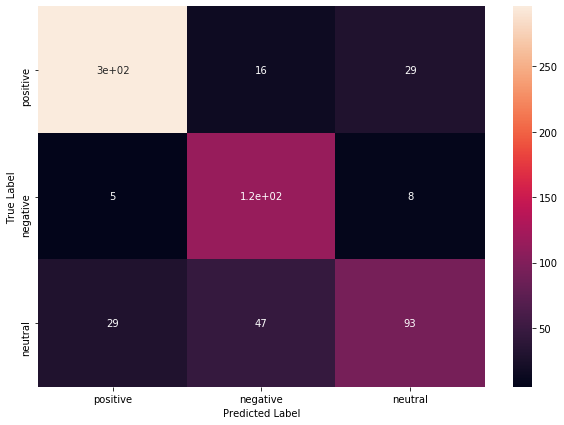

In [18]:
# Calculate metrics and confusion matrix based upon predictions and true labels
cm = sklearn.metrics.confusion_matrix(labels_test.detach().numpy(), predictions_test.detach().numpy().argmax(-1))

df_cm = pd.DataFrame(
    cm,
    index=[i for i in ["positive", "negative", "neutral"]],
    columns=[i for i in ["positive", "negative", "neutral"]])

plt.figure(figsize=(10, 7))

ax = sn.heatmap(df_cm, annot=True)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()